In [96]:
from init_nb import init_notebook
config = init_notebook()

import warnings
from pathlib import Path
import os
import json
import joblib

import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.linalg as npl
import math
import random
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

from sklearn.utils import Bunch

from nilearn import plotting

from bold_dementia.data.study import balance_control, balance_control_cat, load_signals
from bold_dementia.data.memento import Memento, MementoTS, past_diag_AD, healthy_control
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices, reshape_pvalues


#confounds_strategy = config["confounds_strategy"]
confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf", "global_signal"]
}
SOFT = False
ATLAS = "gillig"
CLEAN_SIGNAL = True
MACRO_LABELS = False
PREFIX = "inter-network"
BALANCE_STRAT = ["SEX", "AGE", "sub"]

cache_dir = Path(config["bids_dir"]) / "derivatives" / f"{ATLAS}"

random.seed(1)

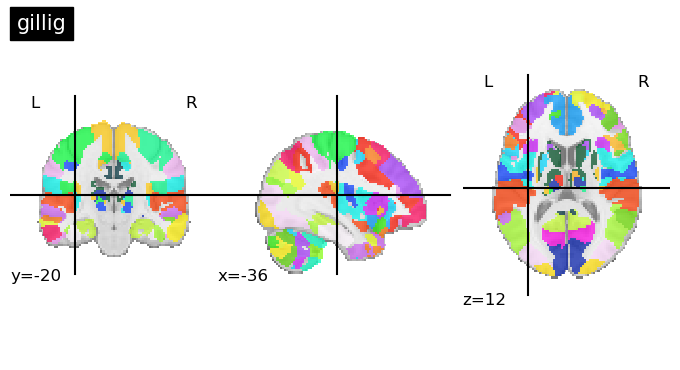

In [97]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot()
plotting.show()

In [98]:
def days_to_onset(row):
    return row.scan_to_onset

memento = MementoTS(cache_dir=cache_dir, target_func=lambda row: row)

res = next(iter(memento))
res

(array([[864.8778 , 700.98096, 826.26526, ..., 945.80444, 870.25397,
         736.55054],
        [864.6619 , 701.8797 , 824.88416, ..., 944.5144 , 864.89105,
         735.107  ],
        [858.71234, 697.0092 , 813.0122 , ..., 946.0808 , 859.6425 ,
         734.6864 ],
        ...,
        [869.1008 , 698.38635, 825.61005, ..., 950.8133 , 871.7438 ,
         740.6674 ],
        [865.6859 , 695.09845, 821.47156, ..., 949.06335, 869.9499 ,
         738.5443 ],
        [865.9407 , 695.27496, 817.82196, ..., 949.0257 , 868.00116,
         738.56525]], dtype=float32),
 file_path            /georges/memento/BIDS/derivatives/fmriprep-23....
 file_basename        sub-0001_ses-M000_task-rest_space-MNI152NLin6A...
 file_tag                                                          bold
 file_type                                                       nii.gz
 file_fields             ['sub', 'ses', 'task', 'space', 'res', 'desc']
 sub                                                                  

In [99]:
# TODO Compare maps to script
with warnings.catch_warnings(category=FutureWarning, action="ignore"):
    AD_signals_ub, control_signals_ub, pm, nm = load_signals(memento, past_diag_AD, healthy_control, clean_signal=CLEAN_SIGNAL, confounds_strategy=confounds_strategy)


Processing /georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0001/ses-M000/func/sub-0001_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz
Processing /georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0001/ses-M024/func/sub-0001_ses-M024_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz
Processing /georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0001/ses-M048/func/sub-0001_ses-M048_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz
Processing /georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0003/ses-M000/func/sub-0003_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz
Processing /georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0003/ses-M024/func/sub-0003_ses-M024_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz
Processing /georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0004/ses-M000/func/sub-0004_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz
Processing

In [100]:
# We pass a control df with one scan per subject
# TODO Balance option "subject"
balanced_AD, balanced_meta = pm, nm

if "sub" in BALANCE_STRAT:
    balanced_AD = balanced_AD.groupby("sub").sample(n=1, random_state=1234)
    balanced_meta = balanced_meta.groupby("sub").sample(n=1, random_state=1234)

# Balanced age and sex accross groups
if "AGE" in BALANCE_STRAT:
    balanced_AD, balanced_meta = balance_control(
        balanced_AD,
        balanced_meta,
        col_name="current_scan_age"
    )
if "SEX" in BALANCE_STRAT:
    balanced_AD, balanced_meta = balance_control_cat(
        balanced_AD,
        balanced_meta,
        col_name="SEX"
    )

balanced_signals = [control_signals_ub[idx] for idx in balanced_meta.index]
AD_signals = [AD_signals_ub[idx] for idx in balanced_AD.index]

#1, removed current_scan_age =  40.439726027397256, new gap = 5.191699533343382, 910 controls left
#2, removed current_scan_age =  41.31780821917808, new gap = 5.1574604035746034, 909 controls left
#3, removed current_scan_age =  42.41643835616438, new gap = 5.124355802305232, 908 controls left
#4, removed current_scan_age =  44.48767123287672, new gap = 5.093461811481475, 907 controls left
#5, removed current_scan_age =  46.25342465753425, new gap = 5.06444857721732, 906 controls left
#6, removed current_scan_age =  46.85479452054794, new gap = 5.036035722394615, 905 controls left
#7, removed current_scan_age =  47.638356164383566, new gap = 5.008426779003514, 904 controls left
#8, removed current_scan_age =  47.8054794520548, new gap = 4.980941761859256, 903 controls left
#9, removed current_scan_age =  47.92876712328767, new gap = 4.9535324848889815, 902 controls left
#10, removed current_scan_age =  48.3, new gap = 4.926474389187064, 901 controls left
#11, removed current_scan_age 

In [101]:
# Merge series but keep track of indices
time_series = AD_signals + balanced_signals
AD_indices = list(range(len(AD_signals)))
control_indices = list(range(len(AD_signals), len(time_series)))
n = len(time_series)
print(f"Study on {n} subjects")

Study on 730 subjects


In [102]:
from sklearn import covariance
from nilearn.connectome import ConnectivityMeasure


# The sample correlation matrix with relatively short time series
# is a bad estimate of functionnal connectivity

pipe = ConnectivityMeasure(
    covariance.LedoitWolf(),
    kind="covariance"
)


c = pipe.fit_transform(time_series)


In [103]:
# Use Bunch for compatibility with former pipelines
gcov = Bunch(
    covariances_=c,
    precisions_=npl.inv(c) # I don't like this
)

In [104]:
AD_cov = gcov.covariances_[AD_indices, :, :].mean(axis=0)
AD_prec = gcov.precisions_[AD_indices, :, :].mean(axis=0)

control_cov = gcov.covariances_[control_indices, :, :].mean(axis=0)
control_prec = gcov.precisions_[control_indices, :, :].mean(axis=0)

In [105]:
# We store matrices for further analysis in network_analysis.py
name = f"atlas-{atlas.name}_{PREFIX}"
for k, v in confounds_strategy.items():
    name += "_"
    if isinstance(v, list):
        v = '-'.join(v)
    name += f"{k}-{v}"

experience_path = Path(config["connectivity_matrices"]) / name


if not os.path.exists(experience_path):
    os.makedirs(experience_path)

metadata = {
    "atlas": atlas.name,
    "confounds_kw": confounds_strategy,
    "macro_labels": MACRO_LABELS
}
with open(experience_path / "parameters.json", "w") as stream:
    json.dump(metadata, stream)

joblib.dump(gcov.covariances_[AD_indices, :, :], experience_path / "AD.joblib")
joblib.dump(gcov.covariances_[control_indices, :, :], experience_path / "control.joblib")

joblib.dump(AD_signals_ub, experience_path / "AD_series_ub.joblib")
joblib.dump(control_signals_ub, experience_path / "control_series_ub.joblib")
pm.to_csv(experience_path / "AD_series_ub.csv")
nm.to_csv(experience_path / "control_series_ub.csv")

balanced_AD.to_csv(experience_path / "balanced_AD.csv")
balanced_meta.to_csv(experience_path / "balanced_control.csv")

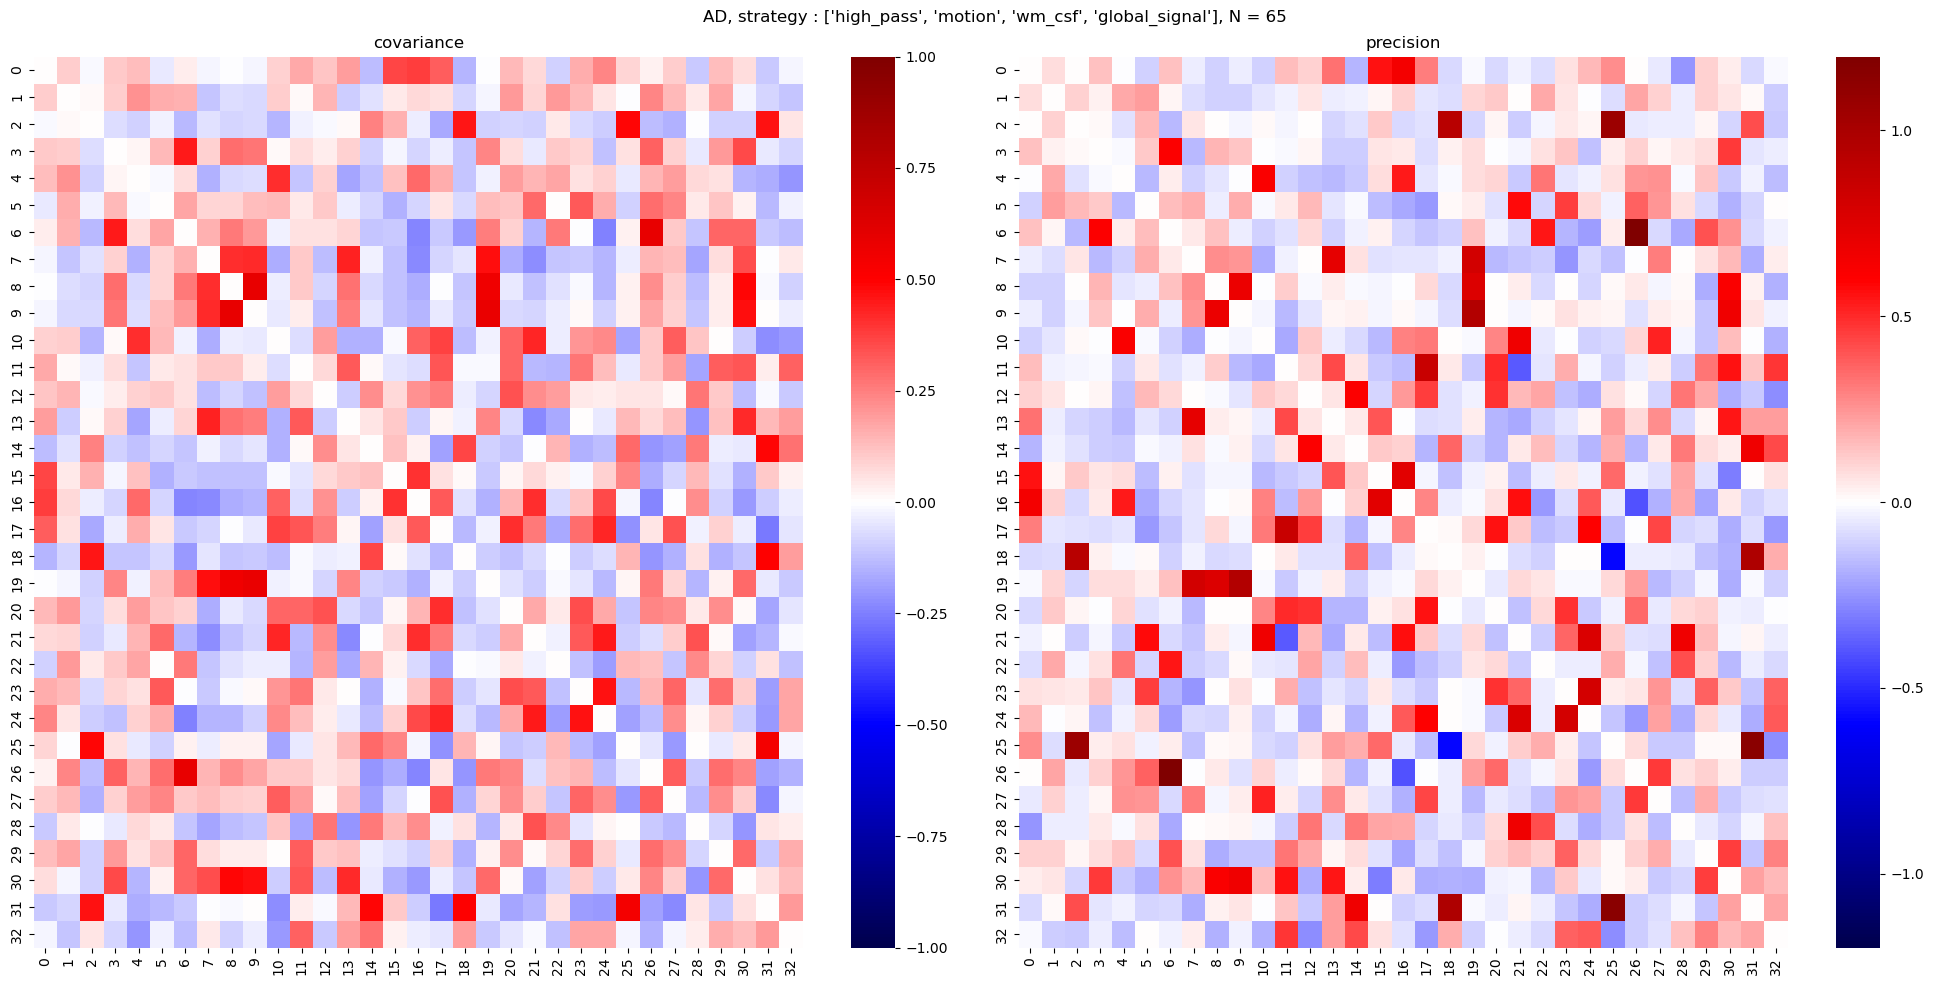

In [106]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

# Mean ou pas mean?
plot_matrices(AD_cov, -AD_prec, f"AD, {title}, N = {len(AD_signals)}", atlas.labels, macro_labels=MACRO_LABELS)

plotting.show()

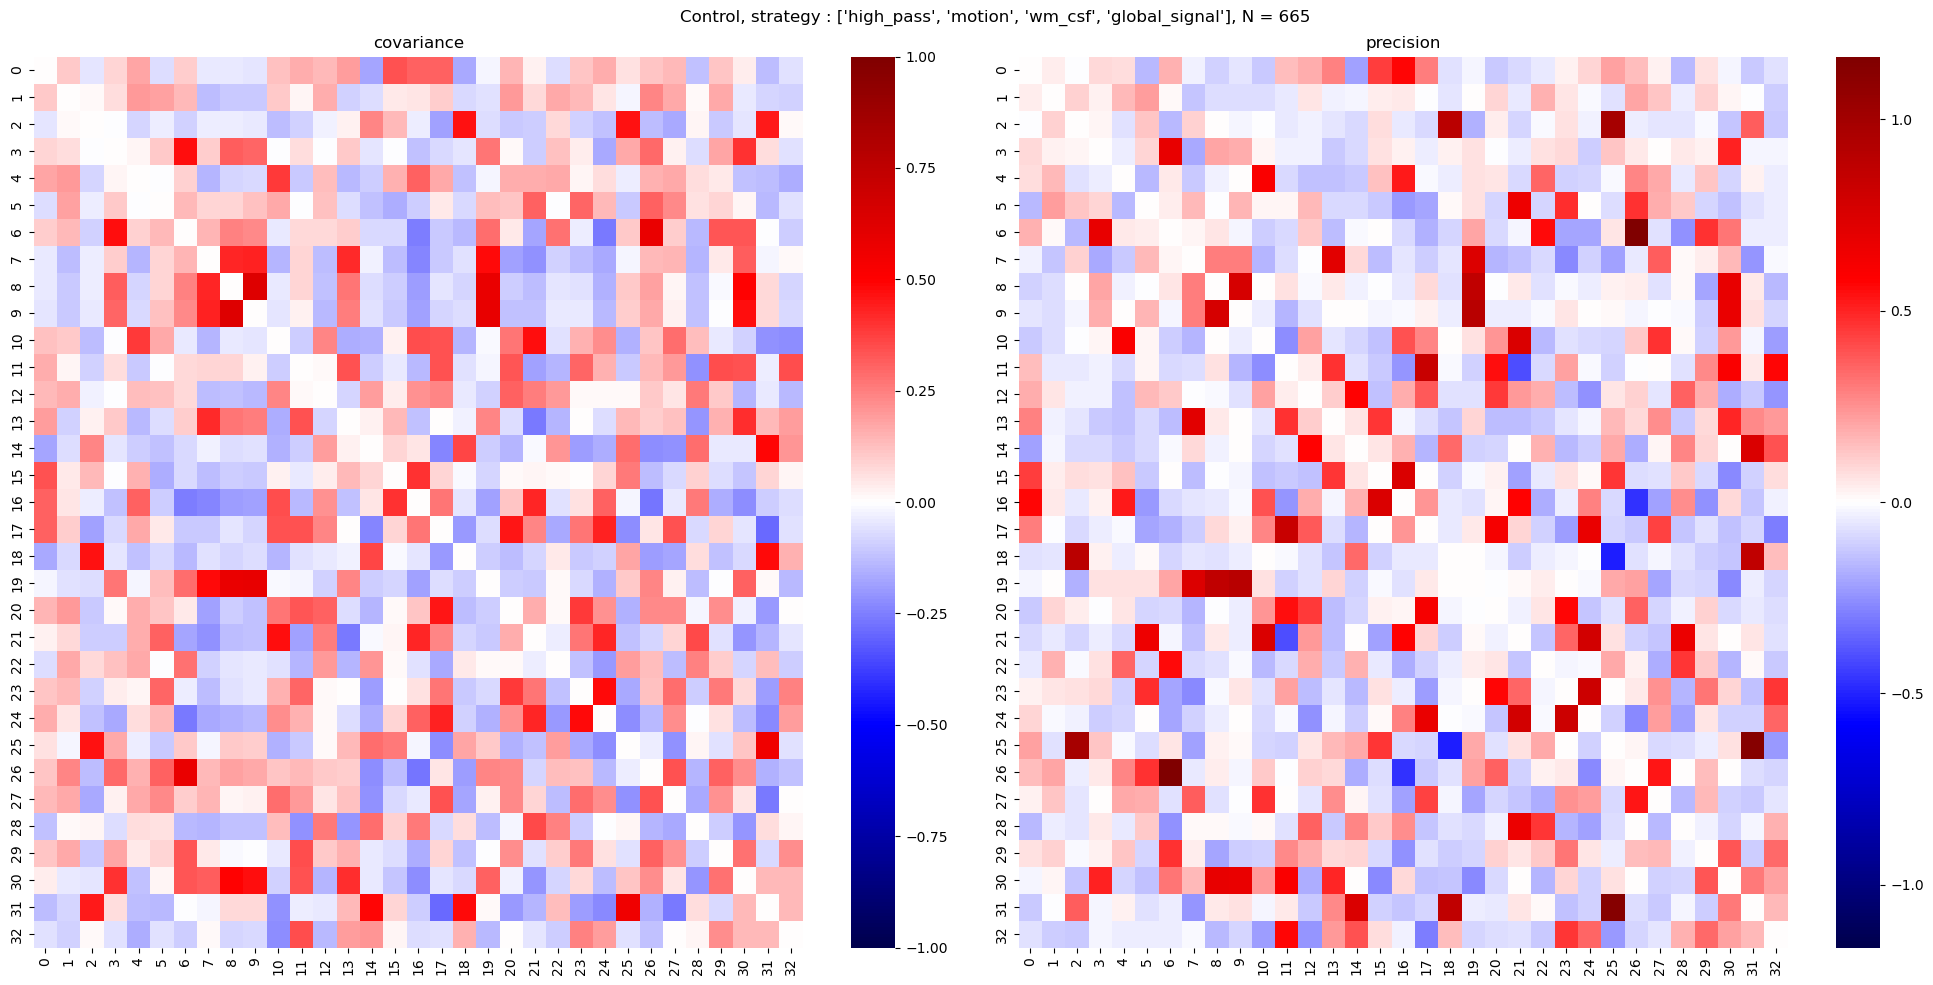

In [107]:
plot_matrices(control_cov, -control_prec, f"Control, {title}, N = {len(balanced_signals)}", atlas.labels, macro_labels=MACRO_LABELS)

plotting.show()

In [108]:
cov = ttest_ind(
    gcov.covariances_[control_indices, :, :],
    gcov.covariances_[AD_indices, :, :],
    alternative="two-sided"
)

prec = ttest_ind(
    -gcov.precisions_[control_indices, :, :],
    -gcov.precisions_[AD_indices, :, :],
    alternative="two-sided"
)

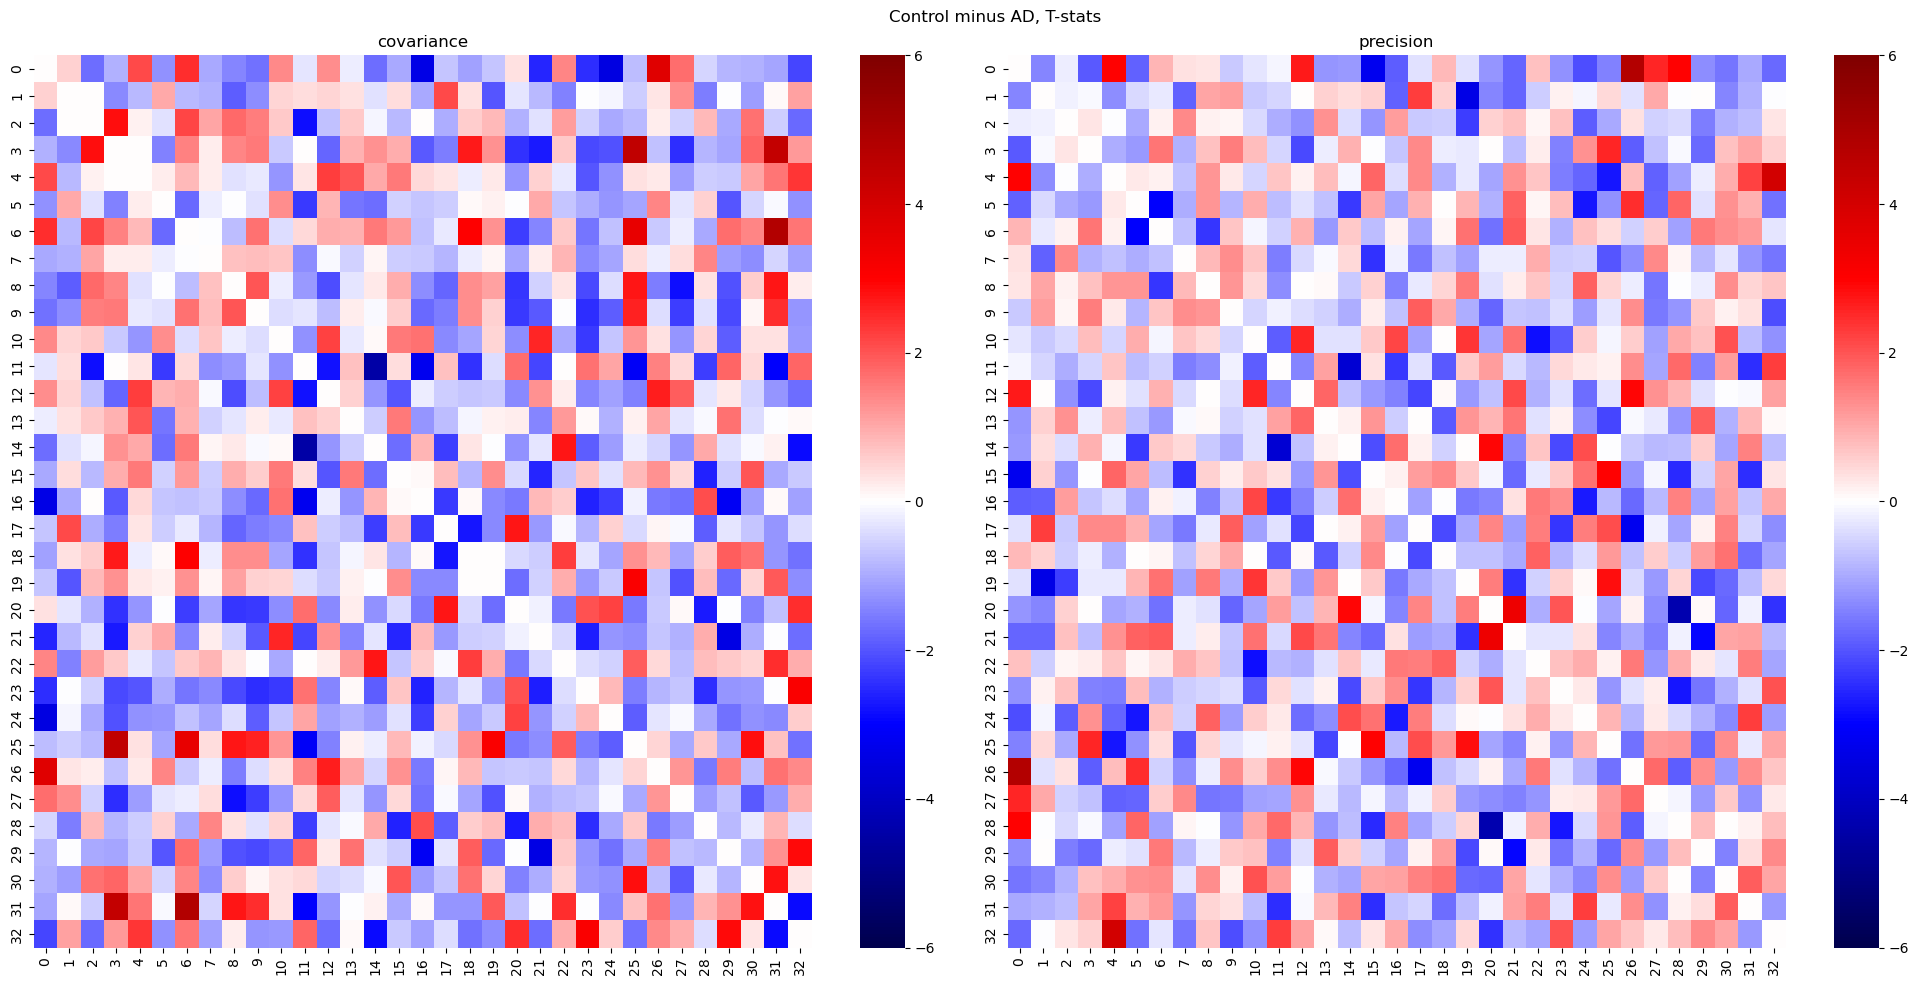

In [109]:
plot_matrices(
    cov[0],
    prec[0],
    "Control minus AD, T-stats",
    atlas.labels,
    macro_labels=MACRO_LABELS,
    cov_bounds=(-6, 6),
    prec_bounds=(-6, 6)
)
plotting.show()

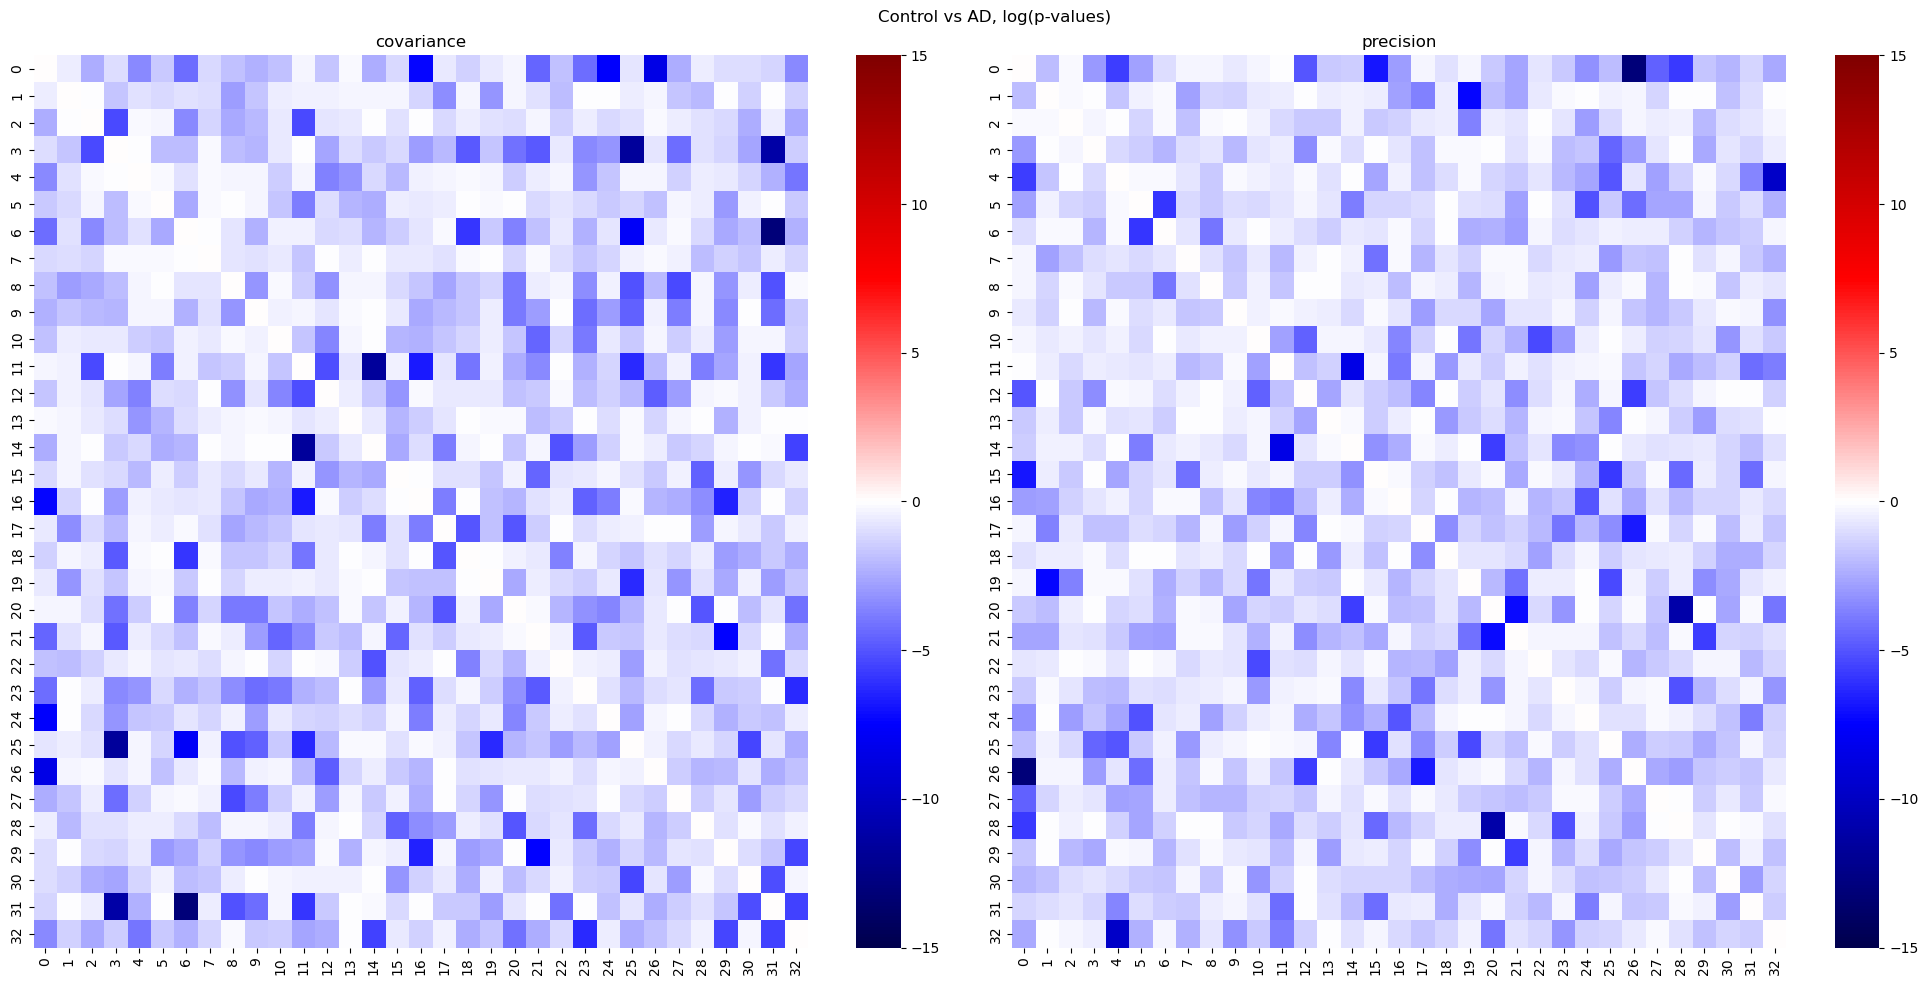

In [110]:
fig, ax1, ax2 = plot_matrices(
    np.log(cov[1]),
    np.log(prec[1]),
    "Control vs AD, log(p-values)",
    atlas.labels,
    macro_labels=MACRO_LABELS,
    cov_bounds=(-15, 15),
    prec_bounds=(-15, 15),
)
plotting.show()


In [111]:
# Bonferroni correction
n = len(cov[1])
n_comparisons = (n**2 - n) / 2

alpha_b = config["alpha"] / n_comparisons

In [112]:
# FDR correction
tri_inds = np.tril_indices(len(cov[1]), k=-1)
pvalues = cov[1][tri_inds]

rejected, corrected_pvalues = fdrcorrection(
    pvalues,
    alpha=0.05
)

rejected_prec, corrected_pv_prec = fdrcorrection(
    prec[1][tri_inds],
    alpha=0.05
)

fdr_mat = reshape_pvalues(corrected_pvalues)
fdr_mat_prec = reshape_pvalues(corrected_pv_prec)

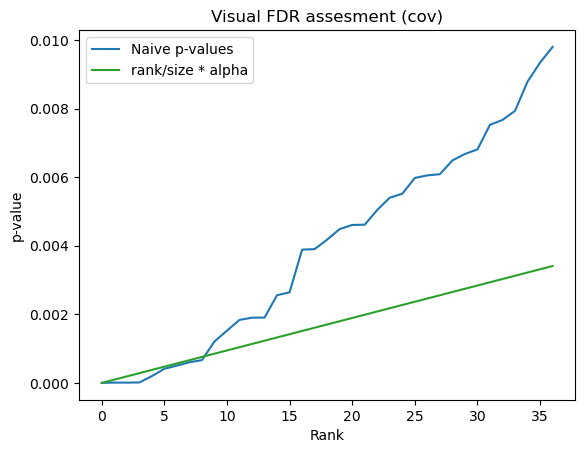

In [113]:
msk = np.where((pvalues < 0.01), True, False)
x = np.arange(pvalues[msk].size)

plt.plot(x, np.sort(pvalues[msk]), label="Naive p-values")

plt.plot(x, x / (pvalues.size) * 0.05, label="rank/size * alpha", color="tab:green")
plt.xlabel("Rank")
plt.ylabel("p-value")
plt.title("Visual FDR assesment (cov)")
plt.legend()
plt.show()

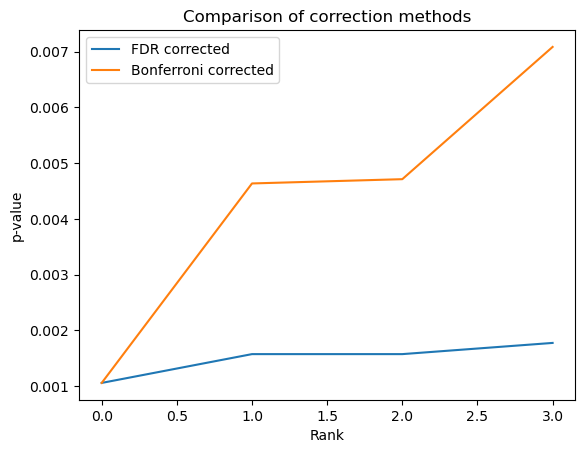

In [114]:
bonferroni_values = np.sort(pvalues) * pvalues.size
msk = np.where(bonferroni_values <= 0.05, True, False)
x = np.arange(bonferroni_values[msk].size)
plt.plot(x, np.sort(corrected_pvalues)[msk], label="FDR corrected")
plt.plot(x, bonferroni_values[msk], label="Bonferroni corrected")
plt.xlabel("Rank")
plt.ylabel("p-value")
plt.title("Comparison of correction methods")
plt.legend()
plt.show()

[]

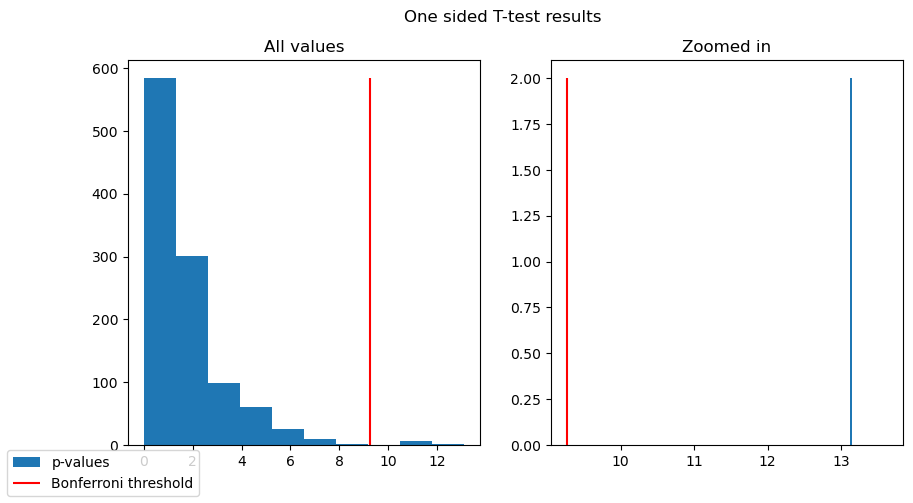

In [115]:
msk = np.where(cov[1] < config["alpha"] / 1e4, True, False) # Zoom in mask
f = lambda x: -np.log(x)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
log_tresh = f(alpha_b)
n, bins, patches = axes[0].hist(f(cov[1].flatten()), bins=10, label="p-values")
axes[0].vlines(log_tresh, 0, max(n), color="red", label="Bonferroni threshold")
axes[0].set_title("All values")

n, bins, patches = axes[1].hist(f(cov[1][msk].flatten()), bins=40)
axes[1].vlines(log_tresh, 0, max(n), color="red")
axes[1].set_title("Zoomed in")

fig.legend(loc="lower left")
fig.suptitle("One sided T-test results")
plt.plot()

In [116]:
# TODO Replot bonferroni

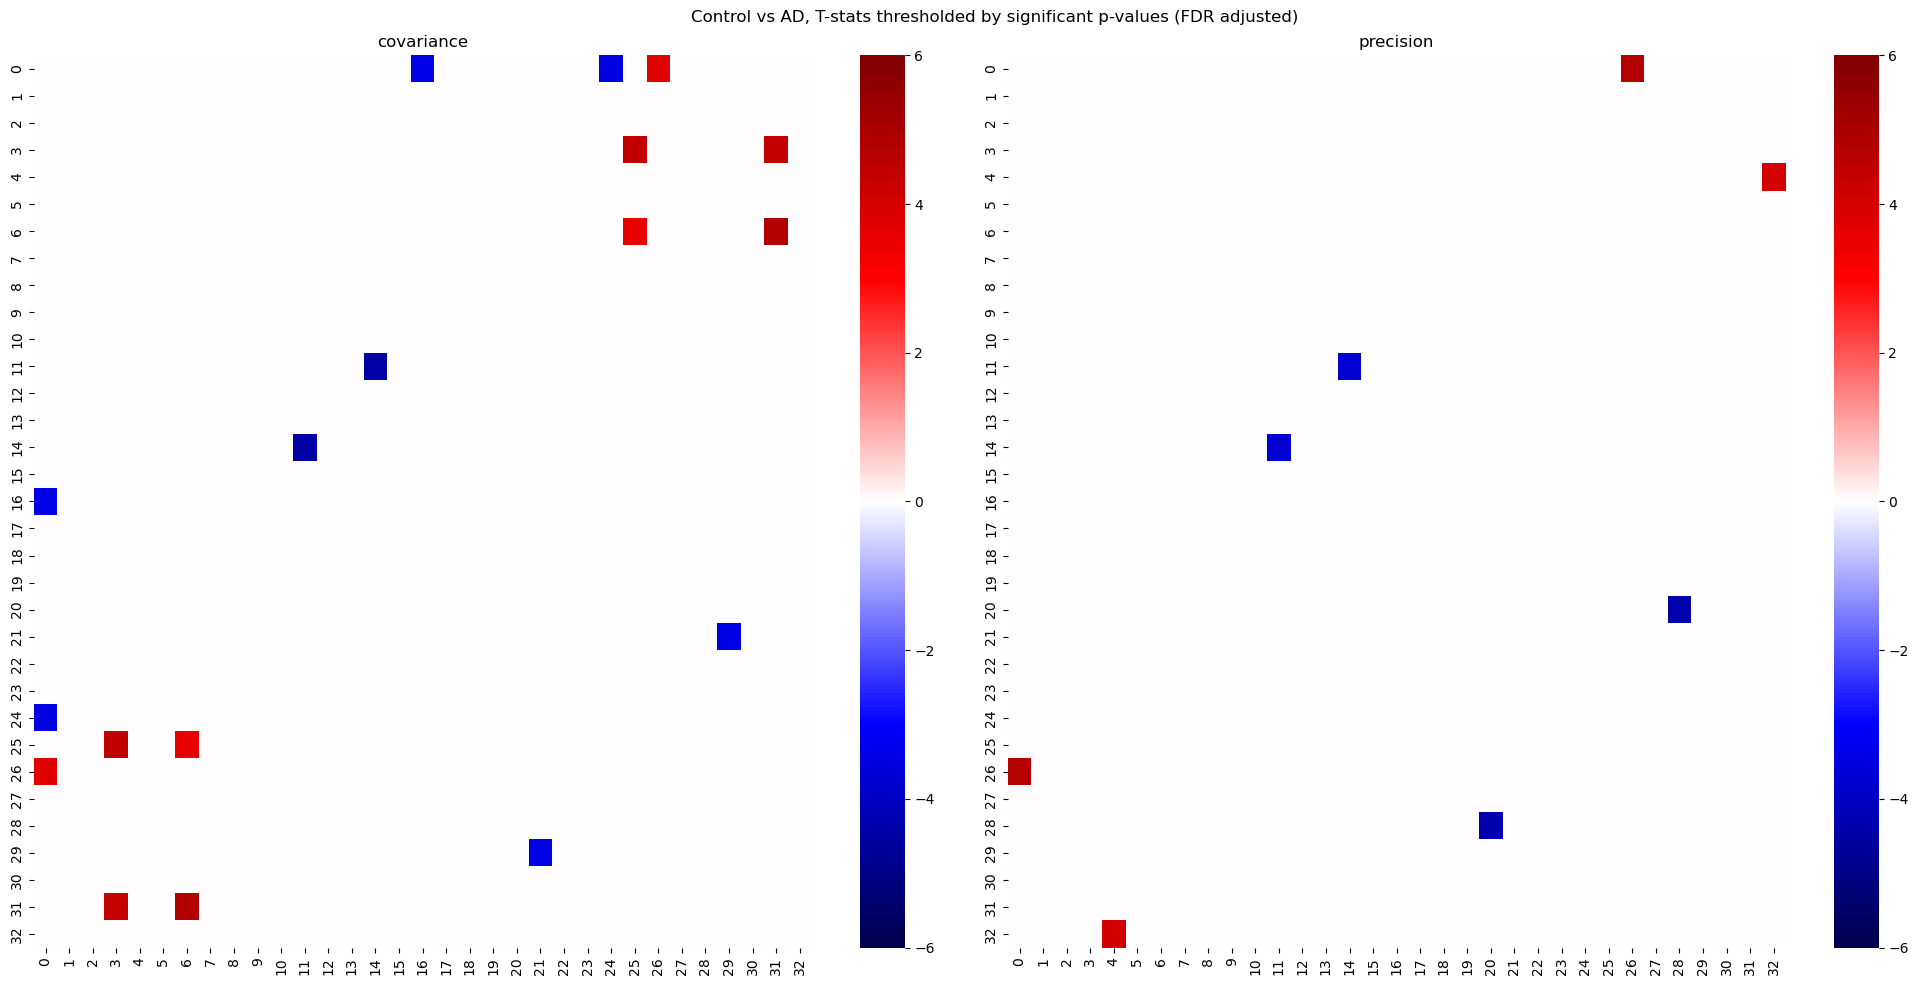

In [117]:
significant_mask = np.where(fdr_mat < config["alpha"], 1, 0)
significant_prec = np.where(fdr_mat_prec < config["alpha"], 1, 0)
fig, ax1, ax2 = plot_matrices(
    cov[0] * significant_mask,
    prec[0] * significant_prec,
    f"Control vs AD, T-stats thresholded by significant p-values (FDR adjusted)",
    atlas.labels,
    macro_labels=MACRO_LABELS,
    cov_bounds=(-6, 6),
    prec_bounds=(-6, 6),
    cmap="seismic",
)

In [118]:
joblib.dump(cov[0], experience_path / "tstats.joblib")
joblib.dump(fdr_mat, experience_path / "fdr_mat.joblib")

['/homes_unix/jlegrand/data/Memento/output/connectivity/atlas-gillig_inter-network_strategy-high_pass-motion-wm_csf-global_signal/fdr_mat.joblib']